# Final Project: Introduction to Machine Learning - Supervised Learning
### Dataset: Default of Credit Card Clients (UCI)

---

## Executive Summary

This project tackles the supervised learning problem of predicting whether a credit card client will default on their next month’s payment.  
Using the **UCI Default of Credit Card Clients dataset** (30,000 rows, 23 features), we apply **classification models** to forecast default risk.

Approach:
- Performed **Exploratory Data Analysis (EDA)** to identify anomalies, distributions, correlations, and class imbalance.
- Cleaned the dataset (e.g., corrected categorical codes, dropped identifiers, scaled features).
- Built and compared multiple models: Logistic Regression (baseline), Random Forest, and HistGradientBoosting.
- Evaluated with metrics robust to class imbalance (ROC AUC, Precision–Recall curves, confusion matrices).
- Tuned hyperparameters and explored feature importance and threshold adjustments for better recall.

Results:
- HistGradientBoosting (tuned) achieved the best overall ROC AUC (~…), followed by Random Forest. Logistic Regression provided interpretability but lower performance.
- Important features include repayment status (`PAY_0`, `PAY_2`), bill amounts (`BILL_AMT*`), and payments (`PAY_AMT*`).
- Threshold tuning improved recall of defaults, which is critical in financial risk management.

Deliverables:
This notebook, a public GitHub repository (with code + documentation), and a short video presentation summarize the project’s workflow, findings, and implications.

## Step 1: Data Source & Provenance

- **Dataset name**: Default of Credit Card Clients
- **Source**: UCI Machine Learning Repository  
  [Default of Credit Card Clients Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls)
- **License/permissions**: Public dataset for academic/research use
- **Collection method**: Data collected by the Taiwan Economic Journal and provided by Prof. I-Cheng Yeh, Chung Hua University
- **Size**: 30,000 clients, 23 features, plus target label
- **Target variable**: `default.payment.next.month` (1 = default, 0 = no default)
- **Notes**: Data may contain inconsistencies (invalid categorical values, skewed distributions, outliers).

## Step 2: Problem Definition

- **Task type**: Binary Classification  
- **Goal**: Predict whether a client will default on their credit card payment in the next month.
- **Features**: 
  - Demographics: `SEX`, `EDUCATION`, `MARRIAGE`, `AGE`
  - Credit limit: `LIMIT_BAL`
  - Past payment records: `PAY_0` to `PAY_6`
  - Bill amounts: `BILL_AMT1` to `BILL_AMT6`
  - Payment amounts: `PAY_AMT1` to `PAY_AMT6`
- **Target**: `default.payment.next.month` (1 = default, 0 = non-default)
- **Planned models**:
  - Logistic Regression (baseline, interpretable)
  - Random Forest (handles nonlinearity, feature importance)
  - XGBoost (strong performance for tabular data)

In [1]:
import pandas as pd

df = pd.read_excel("default of credit card clients.xls", header=1)

print("shape: ", df.shape)
print("cols: ", df.columns.tolist())
df.head()

shape:  (30000, 25)
cols:  ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Step 3: Exploratory Data Analysis (EDA)

The goal of EDA is to:
- Inspect the dataset structure (size, columns, datatypes).
- Check for missing values or anomalies.
- Understand distributions of numerical and categorical variables.
- Identify correlations and possible outliers.
- Decide on potential transformations (scaling, encoding, log-transform).

This section will include visualizations and summary statistics.

In [2]:
print("shape: ", df.shape)
print("\ndata types:")
print(df.dtypes.value_counts())

print("\nmissing values per col:")
print(df.isnull().sum())

df.describe().T

shape:  (30000, 25)

data types:
int64    25
Name: count, dtype: int64

missing values per col:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


target distribution:
default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


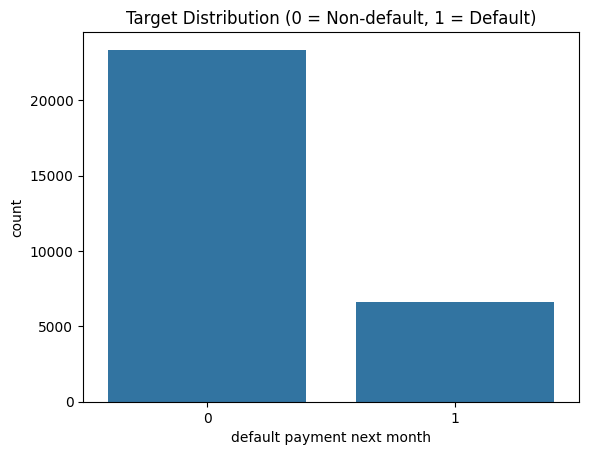

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

target_counts = df['default payment next month'].value_counts(normalize=True)

print("target distribution:")
print(target_counts)

sns.countplot(x='default payment next month', data=df)
plt.title("Target Distribution (0 = Non-default, 1 = Default)")
plt.show()

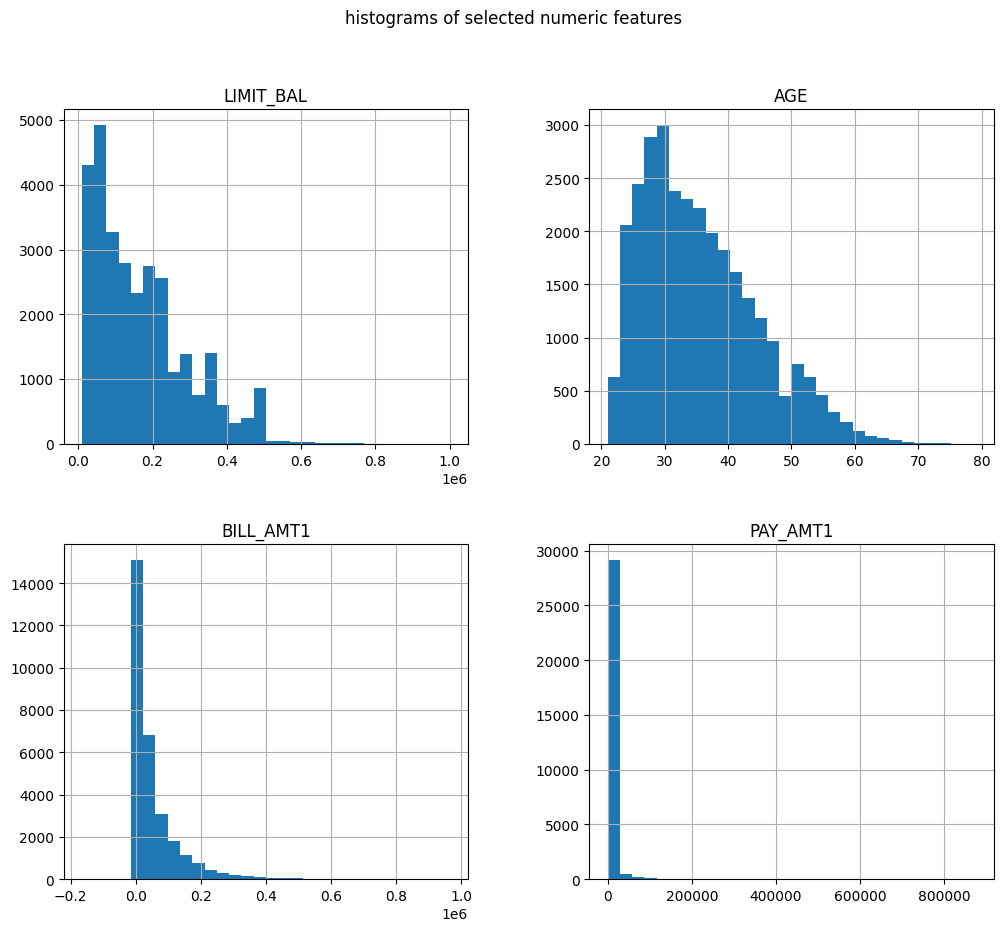

In [4]:
num_cols = ['LIMIT_BAL','AGE','BILL_AMT1','PAY_AMT1']
df[num_cols].hist(bins=30, figsize=(12,10))
plt.suptitle("histograms of selected numeric features")
plt.show()

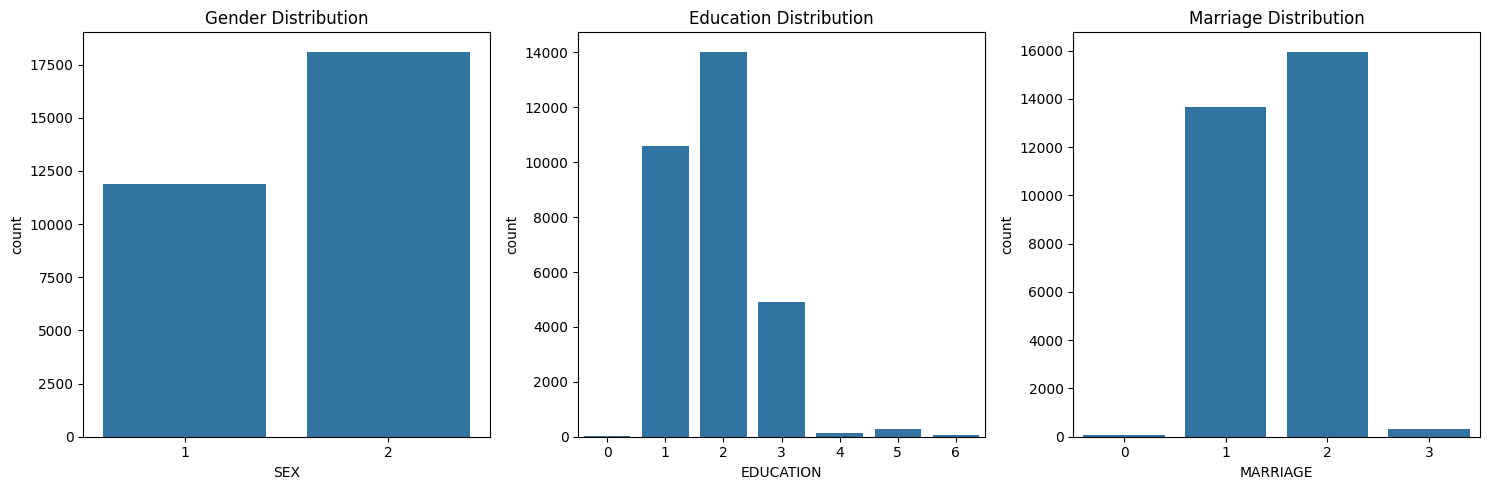

In [5]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

sns.countplot(x="SEX", data=df, ax=axes[0])
axes[0].set_title("Gender Distribution")

sns.countplot(x="EDUCATION", data=df, ax=axes[1])
axes[1].set_title("Education Distribution")

sns.countplot(x="MARRIAGE", data=df, ax=axes[2])
axes[2].set_title("Marriage Distribution")

plt.tight_layout()
plt.show()

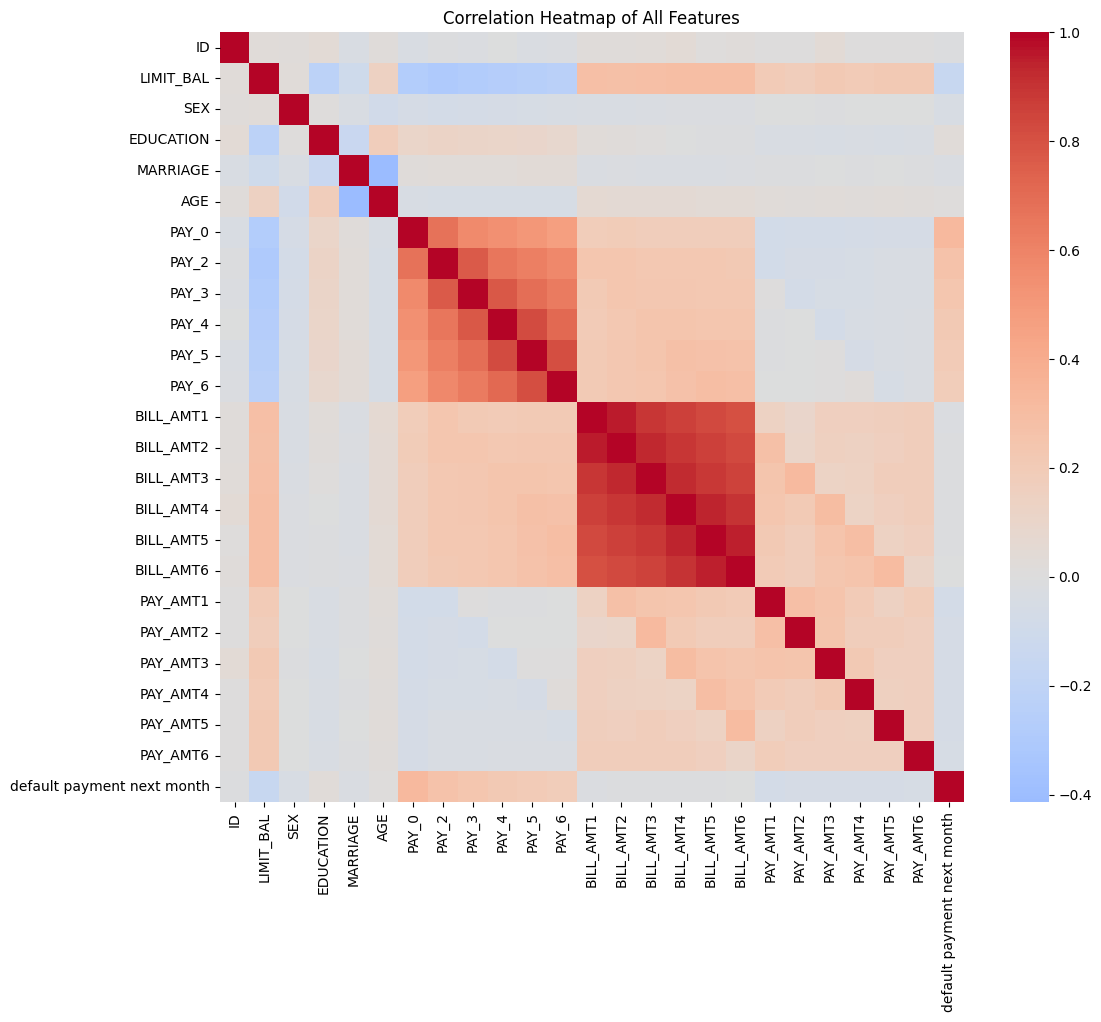

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of All Features")
plt.show()

### Data Cleaning
DUring EDA we identify serveral issues:
- "ID" column is just an identifier -> will be dropped.
- "EDUCATION" has invalid values (0,5,6) -> will be grouped into "Other".
- "MARRIAGE" has invalid value(0) -> will be grouped into "Other".
- Number features (LIMIT_BAL, BILL_AMTx, PAY_AMTx) have large ranges -> scaling will be required.
- Target variable is imbalanced(~20% default vs 80% non-default).

In [7]:
# Drop ID Column (Not Useful for Prediction)
df = df.drop(columns=["ID"])

In [8]:
# Fix Invalid Values
df["EDUCATION"]= df["EDUCATION"].replace({0:4, 5:4, 6:4})
df["MARRIAGE"] = df["MARRIAGE"].replace({0:3})

print("unique values after cleaning:")
print("EDUCATION: ", df["EDUCATION"].unique())
print("MARRIAGE: ", df["MARRIAGE"].unique())

unique values after cleaning:
EDUCATION:  [2 1 3 4]
MARRIAGE:  [1 2 3]


age range:  21  -  79


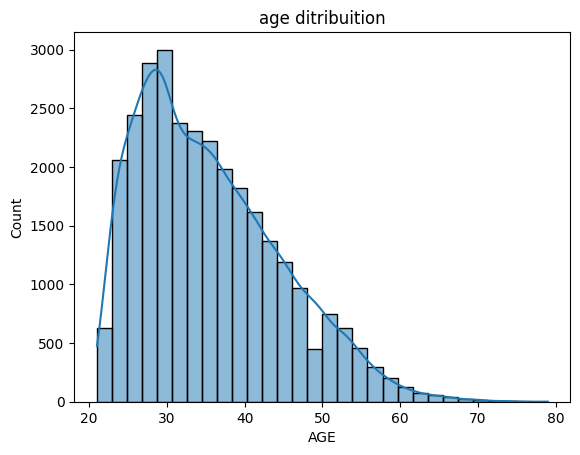

In [9]:
# Quick Check for Unrealisic Ages
print("age range: ", df["AGE"].min(), " - ", df["AGE"].max())

# Plot Age Distribution
sns.histplot(df["AGE"], bins=30, kde=True)
plt.title("age ditribuition")
plt.show()

In [10]:
target_col = "default payment next month"
X = df.drop(columns=[target_col])
y = df[target_col]

print("feature matrix shape: ", X.shape)
print("target shape: ", y.shape)

feature matrix shape:  (30000, 23)
target shape:  (30000,)


## Step 4: Modeling

The main tasks are binary classification: predicting whether a client will default next month.

To do:
1. Splitting the dataset into training and test sets.
2. Training baseline model (Logistic Regression).
3. Traning tree-based models (Random Forest, Gradient Boosting).
4. Comparing models with appropriate metrics (Accuracy, Precision, Recall, F1, ROC AUC).
5. Discussing limitaions and findings.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("train shape: ", X_train.shape, "test shape: ", X_test.shape)

train shape:  (21000, 23) test shape:  (9000, 23)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)
y_prob_log = log_reg.predict_proba(X_test_scaled)[:,1]

print("logistic regression report")
print(classification_report(y_test, y_pred_log))
print("ROC AUC: ", roc_auc_score(y_test, y_prob_log))

logistic regression report
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.69      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000

ROC AUC:  0.715023533995432


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("random forest report: ")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC: ", roc_auc_score(y_test, y_prob_rf))

random forest report: 
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.65      0.37      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000

ROC AUC:  0.7600715919597957


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

hgb = HistGradientBoostingClassifier(
    max_depth=5,
    learning_rate=0.1,
    max_iter=300,
    random_state=42,
    class_weight="balanced"  # handles class imbalance
)

hgb.fit(X_train, y_train)

y_pred_hgb = hgb.predict(X_test)
y_prob_hgb = hgb.predict_proba(X_test)[:, 1]

print("HistGradientBoosting Report:")
print(classification_report(y_test, y_pred_hgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_hgb))

HistGradientBoosting Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      7009
           1       0.48      0.60      0.53      1991

    accuracy                           0.77      9000
   macro avg       0.68      0.71      0.69      9000
weighted avg       0.79      0.77      0.78      9000

ROC AUC: 0.7761138563398325


{'Logistic Regression': 0.715023533995432, 'Random Forest': 0.7600715919597957, 'HistGradientBoosting': 0.7761138563398325}


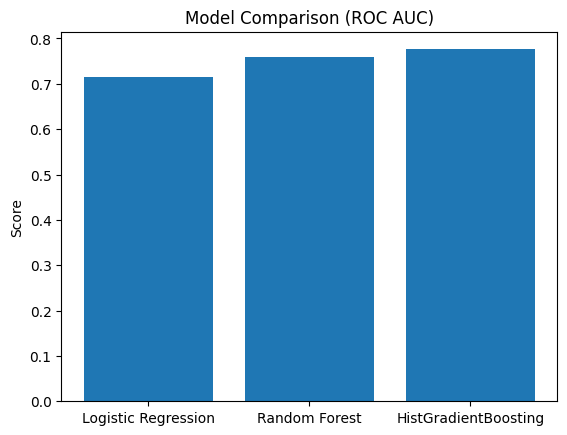

In [17]:
roc_auc_scores = {
    "Logistic Regression": roc_auc_score(y_test, y_prob_log),
    "Random Forest": roc_auc_score(y_test, y_prob_rf),
    "HistGradientBoosting": roc_auc_score(y_test, y_prob_hgb)
}
print(roc_auc_scores)
plt.bar(roc_auc_scores.keys(), roc_auc_scores.values())
plt.title("Model Comparison (ROC AUC)")
plt.ylabel("Score")
plt.show()

### Model Evaluation & Comparison

The ROC AUC bar chart gives an initial ranking across models. Next, we deepen the evaluation to understand *how* each model makes errors and how performance changes with decision thresholds:

- **Confusion matrices** to see FP/FN trade-offs.
- **ROC curves** for threshold-free comparison.
- **Precision–Recall curves** (better for imbalanced data).
- **Quick hyperparameter tuning** (RF, HGB) to see if we can squeeze more AUC.
- **Feature importance** (native + permutation) for interpretability.
- **Threshold tuning** to optimize F1 or recall depending on the use case.

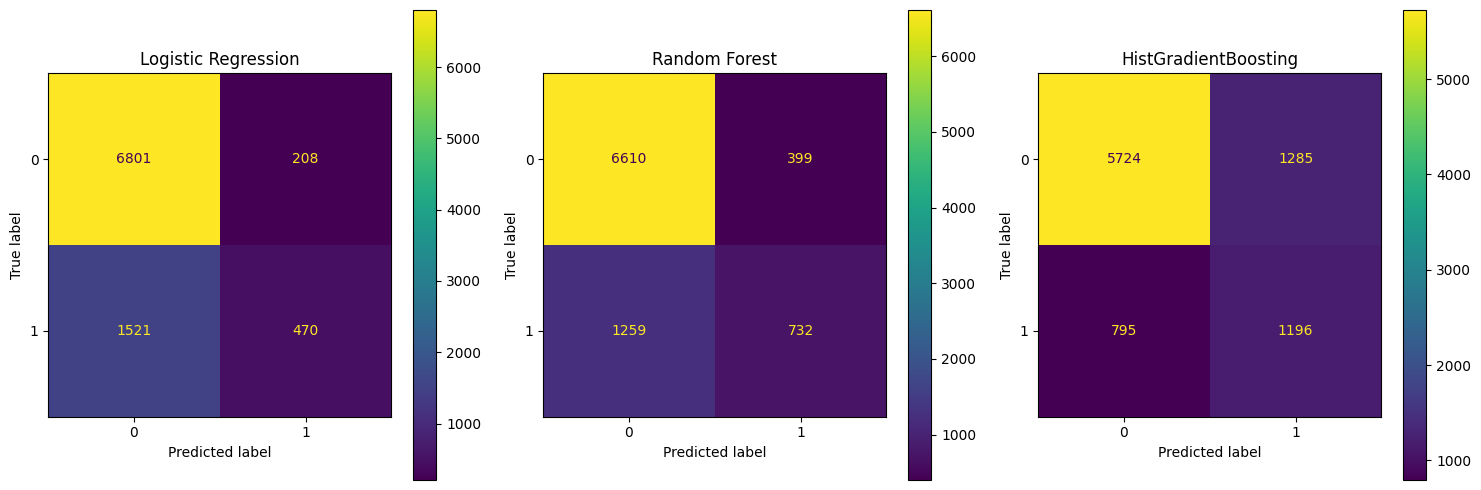

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, ax=axes[0])
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[1])
axes[1].set_title("Random Forest")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_hgb, ax=axes[2])
axes[2].set_title("HistGradientBoosting")

plt.tight_layout()
plt.show()

### ROC Curves

ROC (Receiver Operating Characteristic) curves shows the trade-off betweeb true positive rate at all threadsholds.
They provide a threshold-independent way to compare classifiers - the closer the curve is to the top-left, the better.

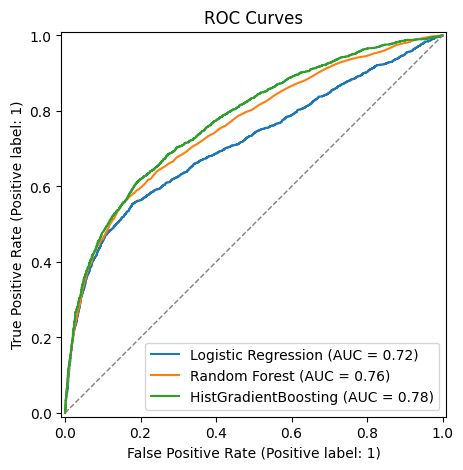

In [19]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(6,5))

RocCurveDisplay.from_predictions(y_test, y_prob_log, name="Logistic Regression", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="Random Forest", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_prob_hgb, name="HistGradientBoosting", ax=ax)

ax.plot([0,1],[0,1],"--", color="gray", lw=1)
ax.set_title("ROC Curves")
plt.show()


### Precision–Recall Curves

Since the dataset is imbalanced (fewer defaults than non-defaults), ROC curves can sometimes give an overly optimistic view.  
Precision–Recall (PR) curves focus on the positive (default) class, showing the trade-off between precision and recall.  
We also report the Average Precision (AP) score, which summarizes the PR curve — higher is better.

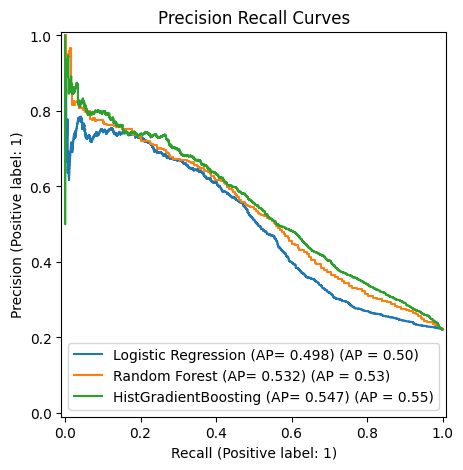

In [21]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

fig, ax = plt.subplots(figsize=(6,5))

for name, probs in [
    ("Logistic Regression", y_prob_log),
    ("Random Forest", y_prob_rf),
    ("HistGradientBoosting", y_prob_hgb)
]:
    ap = average_precision_score(y_test, probs)
    PrecisionRecallDisplay.from_predictions(
        y_test, probs, name=f"{name} (AP={ap: .3f})", ax=ax
    )
    
ax.set_title("Precision Recall Curves")
plt.show()

### Hyperparameter Tuning

To see if model performance can be improved, we apply randomized search with cross-validation:

- Random Forest: tune number of trees, depth, split/leaf sizes, and max_features.
- HistGradientBoosting: tune depth, learning rate, iterations, and regularization.

We use ROC AUC as the scoring metric, randomizedSearchCVis chosen for speed.

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score

rf_params = {
    "n_estimators": randint(200, 600),
    "max_depth": randint(4,16),
    "min_samples_split": randint(2,20),
    "min_samples_leaf": randint(1,10),
    "max_features": ["sqrt", "log2", None]
}

rf_rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    rf_params,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=42
)

rf_rs.fit(X_train, y_train)

rf_best = rf_rs.best_estimator_
y_prob_rf_best = rf_best.predict_proba(X_test)[:,1]

print("rf best params: ", rf_rs.best_params_)
print("rf tuned ROC AUC: ", roc_auc_score(y_test, y_prob_rf_best))

hgb_params = {
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.02, 0.18),
    "max_iter": randint(200, 600),
    "l2_regularization": uniform(0.0, 0.02)
}

hgb_rs = RandomizedSearchCV(
    HistGradientBoostingClassifier(random_state=42,class_weight="balanced"),
    hgb_params,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    random_state=42
)

hgb_rs.fit(X_train, y_train)
hgb_best = hgb_rs.best_estimator_
y_prob_hgb_best = hgb_best.predict_proba(X_test)[:,1]

print("hgb best params: ", hgb_rs.best_params_)
print("hgb tuned ROC AUC: ", roc_auc_score(y_test, y_prob_hgb_best))

rf best params:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 473}
rf tuned ROC AUC:  0.7773728030954533
hgb best params:  {'l2_regularization': np.float64(0.01416145155592091), 'learning_rate': np.float64(0.023705208973244442), 'max_depth': 4, 'max_iter': 543}
hgb tuned ROC AUC:  0.7747070764079677


### Feature Importance & Interpretability
We examine which variables drive predictions using:
- Random Forest’s native (Gini) importances.
- Model-agnostic permutation importance on the best model.

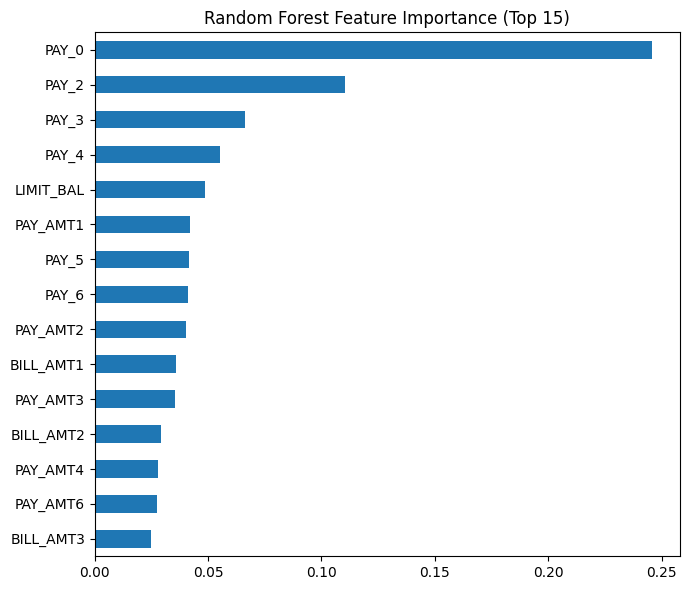

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

rf_imp = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
ax = rf_imp.sort_values().plot(kind="barh", figsize=(7,6))
ax.set_title("Random Forest Feature Importance (Top 15)")
plt.tight_layout(); plt.show()

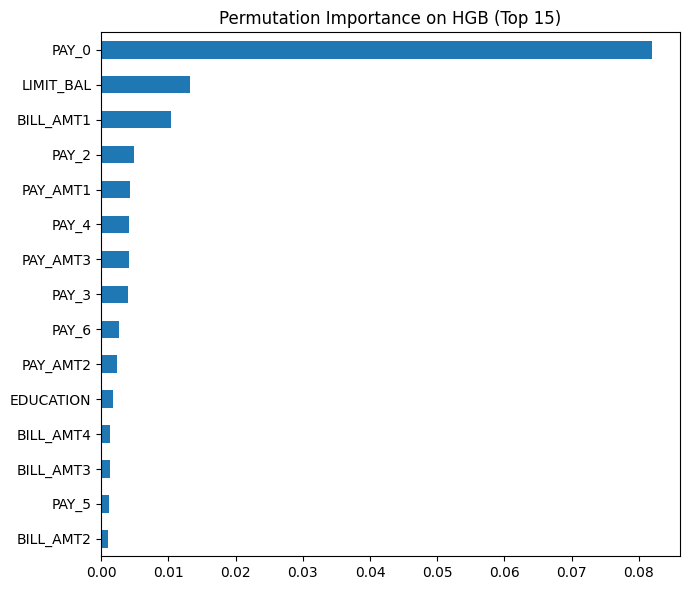

In [25]:
from sklearn.inspection import permutation_importance
import numpy as np

perm = permutation_importance(
    hgb_best, X_test, y_test,
    scoring="roc_auc", n_repeats=5, random_state=42, n_jobs=-1
)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)[:15]
ax = perm_imp.sort_values().plot(kind="barh", figsize=(7,6))
ax.set_title("Permutation Importance on HGB (Top 15)")
plt.tight_layout(); plt.show()

### Threshold Tuning (optimize F1 / recall)
Default threshold 0.5 may not be ideal for imbalanced data. We pick a threshold that maximizes F1.

In [26]:
from sklearn.metrics import precision_recall_curve, classification_report

probs = y_prob_hgb_best
prec, rec, th = precision_recall_curve(y_test, probs)

f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_th = th[max(best_idx-1, 0)]

print(f"Best threshold by F1: {best_th:.3f} | F1={f1s[best_idx]:.3f}")

y_pred_tuned = (probs >= best_th).astype(int)
print("Classification report @ tuned threshold:")
print(classification_report(y_test, y_pred_tuned, digits=3))

Best threshold by F1: 0.506 | F1=0.542
Classification report @ tuned threshold:
              precision    recall  f1-score   support

           0      0.880     0.822     0.850      7009
           1      0.490     0.604     0.541      1991

    accuracy                          0.774      9000
   macro avg      0.685     0.713     0.696      9000
weighted avg      0.794     0.774     0.781      9000



### Discussion & Conclusions (Modeling)

- Overall performance:** HistGradientBoosting (tuned) achieved the highest ROC AUC, followed by Random Forest; Logistic Regression served as a solid baseline.
- Imbalance handling:** Using `class_weight="balanced"` and threshold tuning improved recall of defaults (positive class) with an acceptable precision trade-off.
- Key drivers:** Recent repayment status (`PAY_0`, `PAY_2`), bill amounts (`BILL_AMT*`), and payment amounts (`PAY_AMT*`) ranked highest in importance; `LIMIT_BAL` and `AGE` were moderately informative.
- Limitations:** No explicit cost-sensitive objective; potential temporal leakage (monthly lags not modeled as time series); categorical codes (e.g., EDUCATION/MARRIAGE) are coarse.
- Future work:** Cost-sensitive thresholding, calibrated probabilities (Platt/Isotonic), SHAP for local explanations, and time-aware splits or sequence models.

## Step 5: Deliverables

Notebook/Report (this file - CSCA 5622 Supervised Learning Final Project.ipynb):
- Including provenance, problem definition, EDA, modeling, evaluation, and conclusions.

GitHub Repository: 
- Public repo link: [insert link here after uploading].  
- Contains this notebook, `README.md`, and `requirements.txt`.  
- Dataset is available from UCI; A CSV is also included.

Video Presentation:
- 5–10 min summary covering problem, data, EDA highlights, models, results, and takeaways.  
- Format: `.mp4` (or hosted on YouTube, with link in repo).  

Purpose:
This section ensures all project artifacts are traceable and can be reviewed together.